# Simulate JEMRIS Phantom with MRZero
(C) 2025 Forschungszentrum Jülich

Author: Jörg Felder

<span style="color:red">ATTENTION: This currently only works without the devcontainer.</span> I need to create a container that has JEMRIS installed.

In [1]:
# check for dependencies
import importlib.util

packages = ['pytorch_finufft', 'git', 'pypulseq', 'MRzeroCore']
for package in packages:
    spec = importlib.util.find_spec(package)
    if (spec==None):
        print('Need to isntall package {}.'.format(package))
        if package=='pytorch_finufft':
            %pip install pytorch-finufft
        elif package=='git':
            %pip install gitpython
        elif package=='pypulseq':
            %pip install git+https://github.com/jumri-project/pypulseq.git@devel
        elif package=='MRzeroCore':
            %pip install MRzeroCore

In [2]:
import os
import git

# clone qrage, if not present
if( not os.path.isdir('../qrage') ):
    print('qrage not installed, cloning ...')
    git.Git('../').clone('https://github.com/jumri-project/qrage.git')

In [3]:
%load_ext autoreload
%autoreload 2

import sys

sys.path.insert(0, '../qrage/src/qrage')

In [4]:
import h5py
import torch

import numpy as np
import pypulseq as pp
import matplotlib.pyplot as plt

In [5]:
# Set parameters
filepath = '.'

adiabatic_pulse_type: str='hypsec_n'        # valid pulse types ["hypsec", "hypsec_n", "wurst"]
adiabatic_pulse_overdrive=1.5

useJemrisSeq = False  # use JEMRIS sequence file
SimulateInversionEfficiency = True  # simulate inversion efficiency

phantom_slices = 1

system = pp.Opts(
    max_grad=28,
    grad_unit="mT/m",
    max_slew=150,
    slew_unit="T/m/s",
    rf_ringdown_time=20e-6,
    rf_dead_time=100e-6,
    # adc_dead_time=0,
    adc_dead_time=20e-6,
    grad_raster_time=50*1e-6
)

## 1. Set up Phantom

In [6]:
# Read JEMRIS sample file
# filename = 'SheppLogan.h5'                                                # Standard SheppLogan Phanrom
samplefilename = 'sample_DoubleSphere_R75_DX1p0_T1_1000_2000_T2_25_30.h5'         # Concenrtic spheres
fullsamplefilename = os.path.join(filepath, samplefilename)

## Alternate phantom

In [7]:
# # Uncomment the following lines to use the default brain phantom

# sz = [128, 128]
# obj_p = mr0.VoxelGridPhantom.load_mat('numerical_brain_cropped.mat', size=torch.tensor([0.2, 0.2, 0.001]))
# obj_p = obj_p.interpolate(sz[0], sz[1], 1)
# # Manipulate loaded data
# obj_p.D *= 0
# obj_p.B0 *= 0
# obj_p.plot()

# # Convert Phantom into simulation data
# obj_p = obj_p.build()

# data = obj_p

## 2. Create DI and standard GRE sequence with inversion pulse used in the QRAGE sequence

In [8]:
import math
from sequence.inversion import make_adiabatic_pulse

In [9]:
def write_sequence (plot: bool, write_seq: bool, seq_filename: str = 'gre_DI.seq', remove_prep_pulses: bool = False):
    
    # choose the scanner limits
    sys = system
    
    
    # Define FOV and resolution
    fov             = 200e-3
    slice_thickness = 5e-3
    n_slices        = 1
    Nread           = 32    # frequency encoding steps/samples
    Nphase          = 32    # phase encoding steps/samples

    # adiabatic pulse properties (default values from qrage sequence)
    adiabatic_pulse_duration: float = 10.24e-3
    adiabatic_pulse_dwell: float = 1e-5

    # Define sequence parameters
    TE              = 5e-3
    TR              = 500e-3
    TI              = 25e-3
    alpha           = 30

    dwell_time  = 10e-5                     # ADC dwell time 
    ro_duration = Nread * dwell_time        # ADC duration

    # Phase cycling
    rf_phase = 0
    rf_inc = 0
    rf_spoiling_inc = 117    

    # define the sequence
    seq = pp.Sequence()

    # Define excitation pulse
    rf, gz, _ = pp.make_sinc_pulse(
        flip_angle = alpha * np.pi / 180, 
        duration = 1e-3,
        slice_thickness = slice_thickness, 
        apodization = 0.5, 
        time_bw_product = 4,
        system = sys, 
        return_gz = True
    )

    # Define adiabatic rf pulse
    rf_adia = make_adiabatic_pulse(
        pulse_type=adiabatic_pulse_type,
        duration=adiabatic_pulse_duration,
        overdrive=adiabatic_pulse_overdrive,
        dwell=adiabatic_pulse_dwell,
        system=sys,
    )

    # Define other gradients and ADC events
    delta_k  =   1 / fov
    gx = pp.make_trapezoid(             # readout
        channel = 'x', 
        flat_area = Nread * delta_k, 
        flat_time = ro_duration, 
        system = sys
    )
    adc = pp.make_adc(
        num_samples = Nread, 
        duration = ro_duration, 
        phase_offset = 0 * np.pi/180,   # Will add offset in read loop
        delay = gx.rise_time, 
        system = sys
    )
    gx_pre = pp.make_trapezoid(         # prephaser readout
        channel = 'x', 
        area = -gx.area / 2, 
        duration = 1e-3, 
        system = sys
    )
    gz_reph = pp.make_trapezoid(        # rephase slice select
        channel = 'z', 
        area = -gz.area / 2, 
        duration = 1e-3, 
        system = sys
    )

    # phase encoding areas
    phase_areas = -(np.arange(Nphase)-Nphase//2)*delta_k

    # Create spoilers in read, phase and in slice
    gx_spoil = pp.make_trapezoid(
        channel = 'x', 
        area = 2 * Nread * delta_k, 
        system = sys
    )
    gy_spoil = pp.make_trapezoid(
        channel = 'y', 
        area = 2 * Nread * delta_k, 
        system = sys
    )
    gz_spoil = pp.make_trapezoid(
        channel = 'z', 
        area = 4 / slice_thickness, 
        system = sys
    )

    # Calculate timing
    if remove_prep_pulses:
        delay_TI = (
        math.ceil(
            (TI + rf_adia.shape_dur /2  - gz.rise_time - gz.flat_time / 2  )
            / seq.grad_raster_time
        )
        * seq.grad_raster_time
    )
    else:
        delay_TI = (
            math.ceil(
                (TI - rf_adia.shape_dur * 3/2 - np.max([pp.calc_duration(gx_spoil), pp.calc_duration(gz_spoil)]) - gz.rise_time - gz.flat_time / 2  )
                / seq.grad_raster_time
            )
            * seq.grad_raster_time
        )
    delay_TE = (
        math.ceil(
            (TE - pp.calc_duration(gx_pre) - gz.fall_time - gz.flat_time / 2 - pp.calc_duration(gx) / 2)
            / seq.grad_raster_time
        )
        * seq.grad_raster_time
    )
    delay_TR = (
        math.ceil(
            (TR - pp.calc_duration(gz) - pp.calc_duration(gx_pre) - pp.calc_duration(gx) - TE - TI)
            / seq.grad_raster_time
        )
        * seq.grad_raster_time
    )
    assert np.all(delay_TI >= 0)
    assert np.all(delay_TE >= 0)
    assert np.all(delay_TR >= pp.calc_duration(gx_spoil, gz_spoil))

    # initial phases
    rf_phase = 0
    rf_inc = 0

    # set counter
    seq.add_block(pp.make_label(label='REV', type='SET', value=1))
    
    # ======
    # CONSTRUCT SEQUENCE
    # ======

    # Loop over slices
    for s in range(n_slices):
        rf.freq_offset = gz.amplitude * slice_thickness * (s - (n_slices - 1) / 2)
        rf_adia.freq_offset = rf.freq_offset

        # Loop over phase encodes and define sequence blocks
        for i in range(Nphase):
                
            rf.phase_offset = rf_phase / 180 * np.pi 
            rf_adia.phase_offset = rf.phase_offset
            adc.phase_offset = rf_phase / 180 * np.pi
            rf_inc = divmod(rf_inc + rf_spoiling_inc, 360.0)[1]
            rf_phase = divmod(rf_phase + rf_inc, 360.0)[1]

            if remove_prep_pulses:
                seq.add_block(pp.make_delay(delay_TI))
            else:
                seq.add_block(rf_adia)
                seq.add_block(gx_spoil, gy_spoil, gz_spoil)
                seq.add_block(rf_adia)
                seq.add_block(pp.make_delay(delay_TI), gx_spoil, gy_spoil, gz_spoil)
            
            seq.add_block(rf, gz)
            gy_pre = pp.make_trapezoid(
                channel = 'y',
                area = phase_areas[i],
                duration = pp.calc_duration(gx_pre),
                system=sys,
            )
            seq.add_block(gx_pre, gy_pre, gz_reph)
            seq.add_block(pp.make_delay(delay_TE))
            seq.add_block(gx, adc)
            gy_pre.amplitude = -gy_pre.amplitude
            spoil_block_contents = [pp.make_delay(delay_TR), gx_spoil, gy_pre, gz_spoil]
            if i != Nphase - 1:
                spoil_block_contents.append(pp.make_label(type='INC', label='LIN', value=1))
            else:
                spoil_block_contents.extend(
                    [
                        pp.make_label(type='SET', label='LIN', value=0),
                        pp.make_label(type='INC', label='SLC', value=1),
                    ]
                )
            seq.add_block(*spoil_block_contents)

    # export sequence definitions
    seq.set_definition('FOV', [fov, fov, slice_thickness])
    #seq.set_definition('TE', TE)
    #seq.set_definition('TR', TR)
    #seq.set_definition('TI', TI)
    seq.set_definition('Nread', Nread)
    seq.set_definition('Nphase', Nphase)

    # check timiing
    ok, error_report = seq.check_timing()

    if ok:
        print('Timing check passed successfully')
    else:
        print('Timing check failed. Error listing follows:')
        [print(e) for e in error_report]
    
    # ======
    # VISUALIZATION
    # ======
    if plot:
        seq.plot(time_range=np.array([0, 1])*TR, time_disp='ms', grad_disp='mT/m')

    # =====
    # Print information
    # =====
    # print('The amplitude of the excitation pulse is {} Hz'.format(np.max(rf.signal)))

    rep = seq.test_report()
    print(rep)

    # pns_ok, pns_norm, pns_component, t_pns = seq.calculate_pns(
    #     hardware='/home/jovyan/scripts/pulseq_lissajous/MP_GPA_K2309_2250V_951A_AS82_GSWD_SAFETY.asc',
    # )

    spects, spects_sos, freq, _ = seq.calculate_gradient_spectrum( plot=True, 
            acoustic_resonances=[{'frequency': 1100, 'bandwidth': 300}, {'frequency': 550, 'bandwidth': 100}])
    plt.show()
    res_freqs = freq[np.argmax(spects, axis=1)]
    print('Resonate frequencies of gradients (x, y, z) are: ', res_freqs)

    # show SAR Plot
    plt.plot()
    pp.SAR.SAR_calc.calc_SAR(seq)
    

    # =========
    # WRITE .SEQ
    # =========
    if write_seq:
        seq.write(seq_filename)

/var/folders/x0/stdn8c895h99g4y89x6mmbvm0015kg/T/ipykernel_51406/704377998.py:36: UserWarning: Specified RF delay 0.00 us is less than the dead time 100 us. Delay was increased to the dead time.
  rf, gz, _ = pp.make_sinc_pulse(
/var/folders/x0/stdn8c895h99g4y89x6mmbvm0015kg/T/ipykernel_51406/704377998.py:47: UserWarning: Specified RF delay 0.00 us is less than the dead time 100 us. Delay was increased to the dead time.
  rf_adia = make_adiabatic_pulse(


Timing check passed successfully
Number of blocks: 289
Number of events:
RF:     96
Gx:    160
Gy:    128
Gz:    160
ADC:     32
Delay:      0
Sequence duration: 16.045120 s
TE: 0.005000 s
TR: 0.501410 s
Flip angle: 30.00 430.77 deg
Unique k-space positions (aka cols, rows, etc.): 32 32 
Dimensions: 2
Spatial resolution: 6.45 mm
Spatial resolution: 6.25 mm
Repetitions/slices/contrasts: 1.0; range: [(1.0, 1.0)]
Cartesian encoding trajectory detected
Max gradient: 1066667 1066667 1142857 Hz/m == 25.05 25.05 26.84 mT/m
Max slew rate: 5333333333 5333333333 5714285714 Hz/m/s == 125.27 125.27 134.21 T/m/s
Max absolute gradient: 1892532 Hz/m == 44.45 mT/m
Max absolute slew rate: 9.46266e+09 Hz/m/s == 222.25 T/m/s
Event timing check passed successfully



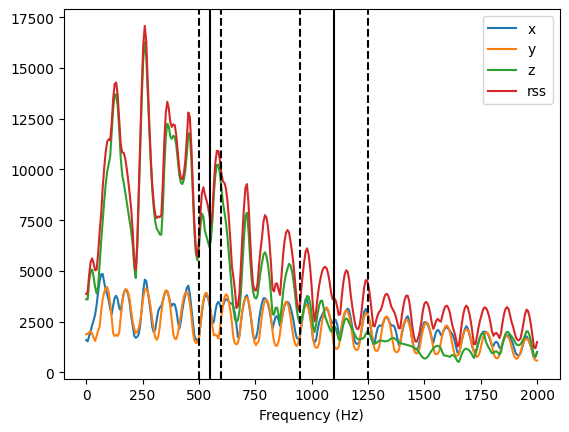

Resonate frequencies of gradients (x, y, z) are:  [ 73.33333333  93.33333333 260.        ]


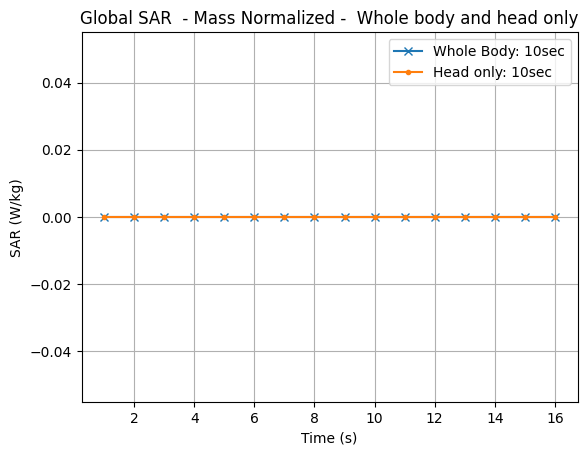

In [10]:
if(SimulateInversionEfficiency):
    seq_filename = os.path.join(filepath, 'gre_DI.seq')
    write_sequence(plot=False, write_seq=True, seq_filename=seq_filename, remove_prep_pulses=False)

Timing check passed successfully
Number of blocks: 193
Number of events:
RF:     32
Gx:     96
Gy:     64
Gz:     96
ADC:     32
Delay:      0
Sequence duration: 16.037440 s
TE: 0.005000 s
TR: 0.501170 s
Flip angle: 30.00 deg
Unique k-space positions (aka cols, rows, etc.): 32 32 
Dimensions: 2
Spatial resolution: 6.45 mm
Spatial resolution: 6.25 mm
Repetitions/slices/contrasts: 1.0; range: [(1.0, 1.0)]
Cartesian encoding trajectory detected
Max gradient: 1066667 94118 1142857 Hz/m == 25.05 2.21 26.84 mT/m
Max slew rate: 5333333333 666666667 5714285714 Hz/m/s == 125.27 15.66 134.21 T/m/s
Max absolute gradient: 1566128 Hz/m == 36.78 mT/m
Max absolute slew rate: 7.84486e+09 Hz/m/s == 184.26 T/m/s
Event timing check passed successfully



/var/folders/x0/stdn8c895h99g4y89x6mmbvm0015kg/T/ipykernel_51406/704377998.py:36: UserWarning: Specified RF delay 0.00 us is less than the dead time 100 us. Delay was increased to the dead time.
  rf, gz, _ = pp.make_sinc_pulse(
/var/folders/x0/stdn8c895h99g4y89x6mmbvm0015kg/T/ipykernel_51406/704377998.py:47: UserWarning: Specified RF delay 0.00 us is less than the dead time 100 us. Delay was increased to the dead time.
  rf_adia = make_adiabatic_pulse(


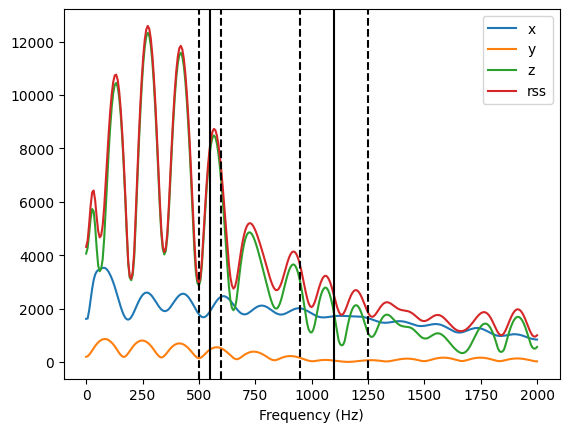

Resonate frequencies of gradients (x, y, z) are:  [ 80.          80.         273.33333333]


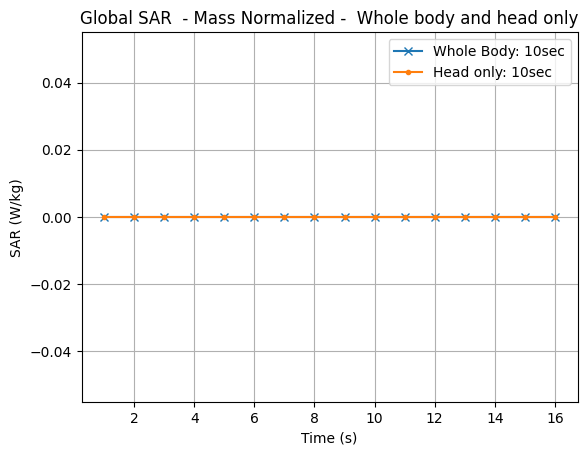

In [11]:
if(SimulateInversionEfficiency):
    seq_filename = os.path.join(filepath, 'gre_noDI.seq')
    write_sequence(plot=False, write_seq=True, seq_filename=seq_filename, remove_prep_pulses=True)

## 3. Simmulate standard GRE sequence for Testing

In [12]:
import lxml.etree
import lxml.builder    
import psutil
import subprocess
import shutil

from seq2xml import seq2xml

In [13]:
if(SimulateInversionEfficiency):
    # Select sequence file
    seq_filename = os.path.join(filepath, 'gre_noDI.seq')

    seq = pp.Sequence()
    pp.Sequence.read(seq, seq_filename)

    if not os.path.isdir('gre_noDI'):
        os.mkdir('gre_noDI')

    # Convert to JEMRIS xml
    seq2xml(seq, seq_name='gre_noDI', out_folder='gre_noDI')


In [14]:
# write simu xml file
if(SimulateInversionEfficiency):
    
    # Content of simu.xml
    SampleURI = os.path.join('..',samplefilename)
    RXCoilURI = "/usr/local/share/jemris/matlab/uniform.xml"
    TXCoilURI = "/usr/local/share/jemris/matlab/uniform.xml"
    SequenceURI = 'gre_noDI.xml'
    # SequenceURI = 'gre.xml'

# Create XML structure
E = lxml.builder.ElementMaker()

SIMULATE = E.simulate
SAMPLE = E.sample
RXCOILARRAY = E.RXcoilarray
TXCOILARRAY = E.TXcoilarray
PARAMETER = E.parameter
SEQUENCE = E.sequence
MODEL = E.model

the_doc = SIMULATE(
    SAMPLE(name="user defined", uri=SampleURI), 
    RXCOILARRAY(uri=RXCoilURI),
    TXCOILARRAY(uri=TXCoilURI),
    PARAMETER(ConcomitantFields="0", EvolutionPrefix="evol", EvolutionSteps="0", RandomNoise="0"),
    SEQUENCE(name="GRE_DI", uri=SequenceURI),
    MODEL(name="Bloch", type="CVODE")
    , name="JEMRIS")   

with open(os.path.join('gre_noDI', 'simu.xml'), 'w') as f:
    print( '<?xml version="1.0" encoding="utf-8"?>', file = f)
    print(lxml.etree.tostring(the_doc, pretty_print=True, encoding='unicode'), file=f)

In [15]:
iNump = psutil.cpu_count(logical=False)

os.chdir('gre_noDI')
subprocess.run(["mpirun", "-np", str(iNump), "pjemris", "simu.xml"])
os.chdir('..')


Parallel jemris 2.9.2 (b0b3084267c41df80e4799beb7378060a0b8f60d)

Model    : Bloch	  , solver = CVODE
Sample   : user defined	  , spins  = 17645
TxArray  : /usr/local/share/jemris/matlab/uniform.xml
RxArray  : /usr/local/share/jemris/matlab/uniform.xml
Sequence : gre_noDI.xml

MacBook-Pro-6.local -> Master Process: send MR sample (17645 spins) to 11 slave(s)

Simulating | ************************************************** | 100% done

Actual simulation took 203.62 seconds.


In [17]:
shutil.copyfile( os.path.join( 'gre_noDI', 'signals_ismrmrd.h5'),  'signals_ismrmrd.h5')

'signals_ismrmrd.h5'

### Reconstruct image

In [18]:
import ismrmrd

In [19]:
if(SimulateInversionEfficiency):
    dset = ismrmrd.Dataset('signals_ismrmrd.h5', 'dataset', create_if_needed=False)

In [20]:
if(SimulateInversionEfficiency):
    # extract the header
    header = ismrmrd.xsd.CreateFromDocument(dset.read_xml_header())
    enc = header.encoding[0]

    # Matrix size
    eNx = enc.encodedSpace.matrixSize.x
    eNy = enc.encodedSpace.matrixSize.y
    eNz = enc.encodedSpace.matrixSize.z
    rNx = enc.reconSpace.matrixSize.x
    rNy = enc.reconSpace.matrixSize.y
    rNz = enc.reconSpace.matrixSize.z

    # Field of View
    eFOVx = enc.encodedSpace.fieldOfView_mm.x
    eFOVy = enc.encodedSpace.fieldOfView_mm.y
    eFOVz = enc.encodedSpace.fieldOfView_mm.z
    rFOVx = enc.reconSpace.fieldOfView_mm.x
    rFOVy = enc.reconSpace.fieldOfView_mm.y
    rFOVz = enc.reconSpace.fieldOfView_mm.z

    # Number of Slices, Reps, Contrasts, etc.
    if header.acquisitionSystemInformation.receiverChannels != None:        # Attention: This flag is not handled correctly by JEMRIS. We will treat this later.
        ncoils = header.acquisitionSystemInformation.receiverChannels
    else:
        ncoils = 1

    if enc.encodingLimits.slice != None:
        nslices = enc.encodingLimits.slice.maximum + 1
    else:
        nslices = 1

    if enc.encodingLimits.repetition != None:
        nreps = enc.encodingLimits.repetition.maximum + 1
    else:
        nreps = 1

    if enc.encodingLimits.set != None:
        nsets = enc.encodingLimits.set.maximum + 1
    else:
        nsets = 1

    if enc.encodingLimits.contrast != None:
        ncontrasts = enc.encodingLimits.contrast.maximum + 1
    else:
        ncontrasts = 1

    print('Parameters dertermined from the raw data file:')
    print('FOV (x,y,z) = {},{},{}'.format(rFOVx, rFOVy, rFOVz))
    print('Encoding matrix size (x,y,z) = {},{},{}'.format(eNx, eNy, eNz))
    print('Image matrix size (x,y,z) = {},{},{}'.format(rNx, rNy, rNz))
    print('Number of coils = {}'.format(ncoils))
    print('Number of slices = {}'.format(nslices))
    print('Number of repetitions = {}'.format(nreps))
    print('Number of sets = {}'.format(nsets))
    print('Number of contrasts = {}'.format(ncontrasts))

Parameters dertermined from the raw data file:
FOV (x,y,z) = 200.0,200.0,5.0
Encoding matrix size (x,y,z) = 64,64,1
Image matrix size (x,y,z) = 64,64,1
Number of coils = 1
Number of slices = 1
Number of repetitions = 1
Number of sets = 1
Number of contrasts = 1


In [21]:
if(SimulateInversionEfficiency):
    # TODO loop through the acquisitions looking for noise scans
    firstacq=0
    for acqnum in range(dset.number_of_acquisitions()):
        acq = dset.read_acquisition(acqnum)
        
        # TODO: Currently ignoring noise scans
        if acq.isFlagSet(ismrmrd.ACQ_IS_NOISE_MEASUREMENT):
            print("Found noise scan at acq ", acqnum)
            continue
        else:
            firstacq = acqnum
            print("Imaging acquisition starts at acq ", acqnum)
            break

    print('Numer of imaging k-sapce lines in the acquistion is {}'.format(dset.number_of_acquisitions()-firstacq))

Imaging acquisition starts at acq  0
Numer of imaging k-sapce lines in the acquistion is 33


In [22]:
if(SimulateInversionEfficiency):    
    # Get number of lines from header
    nlines = (dset.number_of_acquisitions()-firstacq-1) 

    acq = dset.read_acquisition(firstacq+1)
    nsamples = len(acq.data[0])

    # We are expecting nsets * ncontrasts * eNy data sets
    nlines_expected = nsets * ncontrasts * eNy

    if nlines != nlines_expected:
        firstacq = nlines - nlines_expected
        nlines = nlines_expected
        print("Start of imaging acquisition adopted to ", firstacq)
        print('Numer of imaging k-sapce lines in the acquistion adopted to {}'.format(dset.number_of_acquisitions()-firstacq))

    print('Number of qcquistion lines reduced to {}'.format(nlines))
    print('Number of samples per line is {}'.format(nsamples))

Start of imaging acquisition adopted to  -32
Numer of imaging k-sapce lines in the acquistion adopted to 65
Number of qcquistion lines reduced to 64
Number of samples per line is 32


In [24]:
if(SimulateInversionEfficiency):    
    # Read first data line and get shape
    acq = dset.read_acquisition(firstacq+1)
    if np.ndim(acq.data) == 2:
        ncoils = acq.data.shape[0]
        if ncoils > 1:
            print('Receive coil array detected: \n\tThe header information for coil arrays is not set by JEMRIS, so that a coil array con only be detected using the k-spae data shape.')
            print('This data has {} receive channels. Adjusted ncoils accordingly.'.format(ncoils))

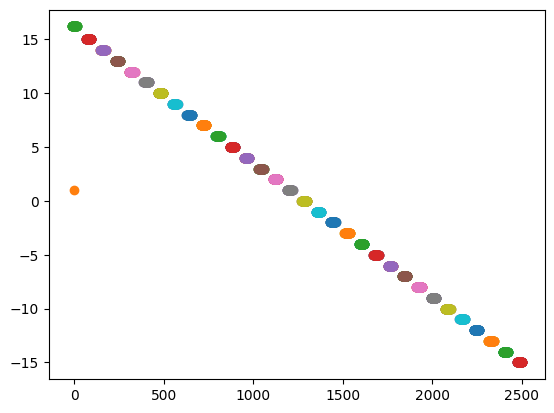

In [25]:
# Plot k-space lines
fig = plt.figure()
ax = plt.axes()

# Loop through the rest of the acquisitions and plot lines
for acqnum in range(firstacq + 1,dset.number_of_acquisitions()): 
    acq = dset.read_acquisition(acqnum)
    ax.scatter(acq.traj[:,0], acq.traj[:,1])
    # print('Acqnum {} has shape {}'.format(acqnum, acq.traj[:,0].shape[0]))

In [26]:
# preallocate storrage
all_data = np.zeros( (nlines, ncoils, nsamples), dtype=np.complex64 )
all_kspace = np.zeros( (nlines, nsamples, 3), dtype=np.complex64 )

# assign
for acqnum in range(firstacq + 1, dset.number_of_acquisitions()):
    acq = dset.read_acquisition(acqnum)
    all_data[acqnum-firstacq-1,:] = acq.data
    all_kspace[acqnum-firstacq-1,:,:] = acq.traj

In [27]:
dset.close()

In [28]:
rawdata = np.squeeze(all_data[:,0,:])


In [29]:
if(SimulateInversionEfficiency):
    # fftshift FFT fftshift
    spectrum = torch.fft.fftshift(torch.from_numpy(rawdata))
    space = torch.fft.fft2(spectrum)
    space_NoInv = torch.fft.ifftshift(space)


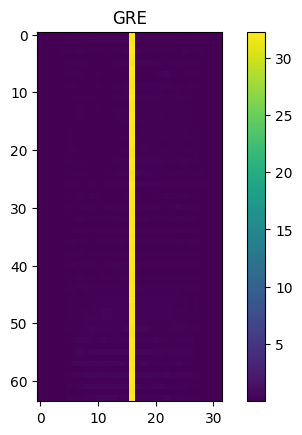

In [30]:
if(SimulateInversionEfficiency):
    plt.title('GRE')
    plt.imshow(np.abs(space_NoInv.numpy()))
    plt.colorbar()

## 4. Simulte GRE Sequence with double inversion

In [ ]:
if(SimulateInversionEfficiency):
    seq_filename = os.path.join(filepath, 'gre_DI.seq')

    seq0 = mr0.Sequence.import_file(seq_filename)

    # Very precise simulation
    # graph = mr0.compute_graph(seq0, data, 10000, 1e-7)
    # signal = mr0.execute_graph(graph, seq0, data, 1e-7, 1e-7)

    # Average precision
    graph = mr0.compute_graph(seq0, data, 10000, 1e-4)
    signal = mr0.execute_graph(graph, seq0, data, 1e-3, 1e-4)

### Reconstruct image

In [ ]:
if(SimulateInversionEfficiency):
    seq = pp.Sequence()
    seq.read(seq_filename)

    permvec = seq.evaluate_labels(evolution='adc')['LIN']
    Nphase = len(permvec)
    Nread = int(seq.adc_library.data[1][0])

    kspace = torch.reshape((signal), (Nphase, Nread)).clone().t()
    ipermvec = np.argsort(permvec)
    kspace=kspace[:,ipermvec]

In [ ]:
if(SimulateInversionEfficiency):
    # fftshift FFT fftshift
    spectrum = torch.fft.fftshift(kspace)
    space = torch.fft.fft2(spectrum)
    space_DI = torch.fft.ifftshift(space)

In [ ]:
if(SimulateInversionEfficiency):
    plt.title('Double Inversion')
    mr0.util.imshow(np.abs(space_DI.numpy()))
    plt.colorbar()

## 5. Compute inversion efficiency map

In [ ]:
if(SimulateInversionEfficiency):
    Mask = np.abs(space_NoInv.numpy()) > 0.15 * np.max(np.abs(space_NoInv.numpy()))
    mr0.util.imshow(Mask)
    plt.colorbar()

In [ ]:
if(SimulateInversionEfficiency):
    MzStart = np.mean(np.abs(space_NoInv.numpy()[Mask]))
    MzEnd = np.mean(np.abs(space_DI.numpy()[Mask]))
    FAEnd = 1/2*np.rad2deg(np.arccos(MzEnd/MzStart))
    IE = np.cos(np.deg2rad(FAEnd))*100

    print('Magnetization (M0z) is {}.'.format(MzStart))
    print('Magnetization Mz after two inversion pulses is {}.'.format(MzEnd))
    print('Flip angle after two inversions is {} degrees.'.format(FAEnd))
    print('Inversion efficiency  is {}%.'.format(IE))

In [ ]:
if(SimulateInversionEfficiency):
    # Plot data for sake of sanity checking
    #
    # See https://matplotlib.org/stable/gallery/color/colorbar_basics.html for colorbar options
    #
    vmin = 0
    vmax = torch.max(torch.abs(space_NoInv))

    SignalRatio = np.zeros_like(space_DI.numpy(), dtype=float)
    np.divide( np.abs(space_DI.numpy()), np.abs(space_NoInv.numpy()), out=SignalRatio, where=Mask==1, dtype=float)
    FAEndPlot = 1/2*np.rad2deg(np.arccos(SignalRatio))
    IEPlot = np.cos(np.deg2rad(FAEndPlot))*100

    f,(ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(10,3.3))
    pos = ax1.imshow(np.abs(space_DI.numpy())*Mask,vmin=vmin, vmax=vmax)
    ax1.set_ylabel('')
    ax1.set_xlabel('')
    ax1.set_title('Double Inversion')
    ax1.set(xticklabels=[])
    ax1.set(yticklabels=[])
    ax1.tick_params(left=False, bottom=False)
    f.colorbar(pos, ax=ax1)
    pos = ax2.imshow(np.abs(space_NoInv.numpy())*Mask,vmin=vmin, vmax=vmax)
    ax2.set_ylabel('')
    ax2.set_xlabel('')
    ax2.set_title('No Inversion')
    ax2.set(xticklabels=[])
    ax2.set(yticklabels=[])
    ax2.tick_params(left=False, bottom=False)
    f.colorbar(pos, ax=ax2)
    pos = ax3.imshow(IEPlot * Mask, vmin=90, vmax=100, cmap='jet')
    ax3.set_ylabel('')
    ax3.set_xlabel('')
    ax3.set_title('Inversion Efficiency')
    ax3.set(xticklabels=[])
    ax3.set(yticklabels=[])
    ax3.tick_params(left=False, bottom=False)
    f.colorbar(pos, ax=ax3)

## 6. Create QRAGE sequence and simulate

In [ ]:
import sys
import platform
from types import SimpleNamespace

In [ ]:
from sequence.qrage import QRAGE

### Create Sequence

In [ ]:
seq_write = True
seq_plot = True
seq_calculate_gradient_spectrum = True
seq_check_timing = False
seq_test_report = False
seq_filename = os.path.join (filepath, 'qrage.seq')

In [ ]:
seq = pp.Sequence()

num_spokes = 64
num_sets = 9
num_echoes = 3
num_partitions_per_block = 8
num_autocalibration_lines = 0
acceleration_factor = 1
fov = np.array([200, 200, num_partitions_per_block]) * 1e-3
matrix_size = np.array([128, 128, num_partitions_per_block ])
readout_bandwidth = 390.625

axes = SimpleNamespace()

xyz = ["x", "y", "z"]

axes.d1 = "x"  # Readout dimension
axes.d2 = "y"  # Inner phase-encoding loop
axes.d3 = "z"  # Outer phase-enconding loop

axes.n1 = xyz.index(axes.d1)
axes.n2 = xyz.index(axes.d2)
axes.n3 = xyz.index(axes.d3)

In [ ]:
seq.set_definition("FOV", fov.tolist())
seq.set_definition("RES", matrix_size.tolist())
seq.set_definition("Name", "QRAGE")

In [ ]:
qrage = QRAGE(
    fov,
    matrix_size,
    axes,
    readout_bandwidth,
    num_spokes,
    num_sets,
    num_echoes,
    num_partitions_per_block,
    num_autocalibration_lines,
    acceleration_factor,
    adiabatic_pulse_type=adiabatic_pulse_type,
    adiabatic_pulse_overdrive=adiabatic_pulse_overdrive,
    debug=False,
    system=system,
)

In [ ]:
qrage.run(seq)

In [ ]:
qrage.get_timing(seq)
print(
    "TR %s ms" % np.round(qrage.TR, decimals=1),
    "dTI %s ms" % np.round(qrage.dTI, decimals=1),
    "TI0 %s ms" % np.round(qrage.TI0, decimals=1),
    "dTE %s ms" % np.round(qrage.dTE, decimals=1),
    "TE0 %s ms" % np.round(qrage.TE0, decimals=1),
)

In [ ]:
if seq_plot:
    seq.plot(time_range=[0, 0.1], grad_disp="mT/m", time_disp="ms", show_blocks=False)

In [ ]:
if seq_calculate_gradient_spectrum:
    spects, spects_sos, freq, _ = seq.calculate_gradient_spectrum( 
        acoustic_resonances=[{'frequency': 1100, 'bandwidth': 300}, {'frequency': 550, 'bandwidth': 100}])
    res_freqs = freq[np.argmax(spects, axis=1)]
    print("Resonance frequencies of gradients (x, y, z) are: ", res_freqs)

In [ ]:
if seq_check_timing:
    ok, error_report = seq.check_timing()
    if ok:
        print("Timing check passed")
    else:
        print("Timing check failed")
        [print(e) for e in error_report]

In [ ]:
if seq_test_report:
    rep = seq.test_report()
    print(rep)

In [ ]:
if seq_write:
    seq.write(seq_filename)

In [ ]:
if useJemrisSeq:
    print('Using JEMRIS sequence file.')

    # converted from JEMRIS using the command:
    # `jemris -x -d -id=1 -f myseq_LowRes_PartLoop_New_Mod_AdiaInvPulse myseq_LowRes_PartLoop_New_Mod_AdiaInvPulse.xml`
    seq_filename = os.path.join(filepath, 'myseq_LowRes_PartLoop_New_Mod_AdiaInvPulse.seq')

    num_spokes = 16
    num_sets = 19
    num_echoes = 9
    num_partitions_per_block = 1
    num_autocalibration_lines = 1
    acceleration_factor = 1
    fov = np.array([220, 220, 1]) * 1e-3
    matrix_size = np.array([64, 64, 1])

    qrage.dTI = 500
    qrage.TI0 = 260
    qrage.dTE = 2.8
    qrage.TE0 = 3.1
    qrage.TR = 9512.4

In [ ]:
# Store sequence information for later processing in h5 file
with h5py.File(os.path.join('..', 'LocalData', 'Simulations', 'qrage_info.h5'), 'w') as f:
    dset = f.create_dataset('num_spokes', data=num_spokes)
    dset = f.create_dataset('num_sets', data=num_sets)
    dset = f.create_dataset('num_echoes', data=num_echoes)
    dset = f.create_dataset('num_partitions_per_block', data=num_partitions_per_block)
    dset = f.create_dataset('num_autocalibration_lines', data=num_autocalibration_lines)
    dset = f.create_dataset('acceleration_factor', data=acceleration_factor)
    dset = f.create_dataset('matrix_size', data=matrix_size)
    dset = f.create_dataset('readout_bandwidth', data=readout_bandwidth)
    
    dset = f.create_dataset('dTI', data=qrage.dTI)
    dset = f.create_dataset('TI0', data=qrage.TI0)
    dset = f.create_dataset('dTE', data=qrage.dTE)
    dset = f.create_dataset('TE0', data=qrage.TE0)
    dset = f.create_dataset('TR', data=qrage.TR)

    dset = f.create_dataset('FoV', data=fov)


### Simulate

In [ ]:
seq0 = mr0.Sequence.import_file(seq_filename)
print(seq_filename)

# Test is gradient scaling is correct
# for rep in seq0:
#     rep.gradm[:, 0] /= 0.2
#     rep.gradm[:, 1] /= 0.2
#     rep.gradm[:, 2] /= 0.2

# seq0.plot_kspace_trajectory()

In [ ]:
# Very precise simulation
# graph = mr0.compute_graph(seq0, data, 10000, 1e-7)
# signal = mr0.execute_graph(graph, seq0, data, 1e-7, 1e-7)

# Average precision
# graph = mr0.compute_graph(seq0, data, 10000, 1e-4)
# signal = mr0.execute_graph(graph, seq0, data, 1e-3, 1e-4)

# low precision simulation
graph = mr0.compute_graph(seq0, data, 200, 1e-4)
if torch.cuda.is_available(): 
    print('>>>> Using CUDA for simulation <<<<.')
    signal = mr0.execute_graph(graph, seq0.cuda(), data.cuda(), 0.01, 0.01).cpu()
else:
    signal = mr0.execute_graph(graph, seq0, data, 0.01, 0.01)

In [ ]:
# Read sequence with pypulseq to get information on acquisition scheme
seq = pp.Sequence()
seq.read(seq_filename)

### Convert into ISMRMRD format (without full header)

In [ ]:
# Tool from Felix Landmeyer to create ISMRMRD dataset from MRZERO simulation
import seqtraj_to_mrd

In [ ]:
# Set required definitions
NCol = matrix_size[1] //acceleration_factor
seq.set_definition('MaxAdcSegmentLength',NCol)

# TEST
# seq.set_definition('MaxAdcSegmentLength',NCol/2)

In [ ]:
# save file
seqtraj_to_mrd.mr0_to_mrd(seq, signal, os.path.join('..','LocalData', 'Simulations', 'qrage.h5'))